In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint

fold = "/home/huy/data/melting_point/"
cols = ['SMILES','Melting Point {measured}']

full_data_1 = pd.read_csv(fold + 'bergstrom.csv')
full_data_2 = pd.read_csv(fold + 'bradley.csv')
full_data_3 = pd.read_csv(fold + 'enamine.csv')
full_data_4 = pd.read_csv(fold + 'ochem.csv')

data_1 = pd.read_csv(fold + 'bergstrom.csv', usecols=cols)
data_2 = pd.read_csv(fold + 'bradley.csv', usecols=cols)
data_3 = pd.read_csv(fold + 'enamine.csv', usecols=cols)
data_4 = pd.read_csv(fold + 'ochem.csv', usecols=cols)

print ("the number of data point is ", data_1.shape)
print ("the number of data point is ", data_2.shape)
print ("the number of data point is ", data_3.shape)
print ("the number of data point is ", data_4.shape)

data = pd.concat([data_1, data_2, data_3, data_4], join='outer', axis=0)

fp_case = 0
fp_len = 128

the number of data point is  (277, 2)
the number of data point is  (2886, 2)
the number of data point is  (22404, 2)
the number of data point is  (21883, 2)


In [2]:
data_4.head()

,SMILES,Melting Point {measured}
0,CN(C1=CC2=NC3=C(C=CC4=C3COCN4)C=C2C=C1)S(C)(=O)=O,300.0
1,CNC1=CC=C2C=C3C=CC(=CC3=NC2=C1CO)N(C)S(C)(=O)=O,150.0
2,CCOC(=O)NC1=CC2=NC3=C(C=CC4=C3COCN4C(=O)OCC)C=...,174.0
3,CCOC(=O)NC1=CC=C2C=C3C=CC4=C(COC(=O)N4)C3=NC2=C1,235.0
4,CCOC(=O)NC1=CC2=NC3=C(C=CC(N)=C3CO)C=C2C=C1,135.0


In [3]:
print ("the number of data point is ", data.shape)

data = data[data[cols[-1]].str.contains("<|>")==False]

print ("the number of data point is ", data.shape)


the number of data point is  (47450, 2)
the number of data point is  (46998, 2)


In [4]:
all_smiles = data['SMILES'].values
all_y = data[cols[-1]].values

print ("THESE SMILES STRINGS ARE NOT CORRECT, REMOVE DATA:")

smiles = []
y = []
for idx in range(len(all_smiles)):
    tsmiles = all_smiles[idx]
    tmol = Chem.MolFromSmiles(tsmiles, sanitize=False)
    problems = Chem.DetectChemistryProblems(tmol)
    if (len(problems)>0):
        print (tsmiles)
    else:
        smiles.append(tsmiles)
        y.append(all_y[idx])

THESE SMILES STRINGS ARE NOT CORRECT, REMOVE DATA:


In [5]:
## correct the values of melting temperature
for idx in range(len(y)):
    item = y[idx]
    if not isinstance(item,float):
        tmp = item.split()
        if (len(tmp)==3):
            y[idx] = 0.5 * (float(tmp[0]) + float(tmp[-1]))
y = [float(i) for i in y]

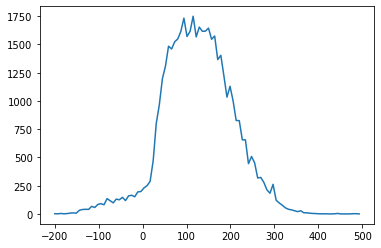

In [6]:
a = np.array(y)
Tmin = -200.0
Tmax =  500.0
npoints = 101
delT = (Tmax-Tmin)/(npoints-1)
bin_arr = np.linspace(Tmin, Tmax, npoints)

import matplotlib.pyplot as plt
hist_vals, hist_bins = np.histogram(a, bins=bin_arr)
plt.plot(hist_bins[:-1],hist_vals)

In [7]:
data = pd.DataFrame(list(zip(smiles, y)), columns = cols)
data['ID'] = np.arange(data.shape[0])
def ymin(Tvalue, Tmin, delT):
    idx = int((Tvalue-Tmin)/delT)
    return Tmin+idx*delT
data['ymin'] = data[cols[-1]].apply(ymin,Tmin=Tmin,delT=delT)

In [8]:
data.head()

,SMILES,Melting Point {measured},ID,ymin
0,CC1CCC1,-161.505,0,-165.0
1,[O-][N+]#N,-90.805,1,-95.0
2,FS(F)(=O)=O,-135.810,2,-137.0
3,CC(C)N(CCC(C(N)=O)(C1=CC=CC=C1)C1=CC=CC=N1)C(C)C,94.775,3,94.0
4,CCN1C=C(C(O)=O)C(=O)C2=CC(F)=C(N3CCNC(C)C3)C(F...,239.775,4,234.0


In [9]:
Tvalue = Tmin
row_nums = []
nlim = 250
while (Tvalue < Tmax):
    tID = data[(data['ymin'] > Tvalue-0.01) & (data['ymin'] < Tvalue+0.01)]['ID'].values
    if (len(tID) > 0):
        if (len(tID)>nlim):
            rand_tID = np.random.permutation(tID)
            row_nums.append(list(rand_tID[:nlim]))
        else:
            row_nums.append(list(tID))
    Tvalue += delT

In [10]:
row_nums = sum(row_nums, [])
print (len(row_nums))

13480


In [13]:
data = data.iloc[row_nums]
print ("the number of data point is ", data.shape)


the number of data point is  (13480, 4)


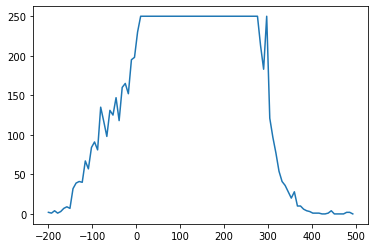

In [14]:
y = data[cols[-1]].values
a = np.array(y)
Tmin = -200.0
Tmax =  500.0
npoints = 101
delT = (Tmax-Tmin)/(npoints-1)
bin_arr = np.linspace(Tmin, Tmax, npoints)

import matplotlib.pyplot as plt
hist_vals, hist_bins = np.histogram(a, bins=bin_arr)
plt.plot(hist_bins[:-1],hist_vals)

In [15]:
data['Mol'] = data['SMILES'].apply(Chem.MolFromSmiles)

In [16]:
from rdkit.Chem.rdMolDescriptors import *

from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect, GetErGFingerprint
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import rdkit.DataStructs.cDataStructs

In [17]:
from rdkit.Chem import rdqueries
def element_count(mol, Zelement):
    q = rdqueries.AtomNumEqualsQueryAtom(Zelement)
    return len(mol.GetAtomsMatchingQuery(q))

In [18]:
from sklearn.preprocessing import StandardScaler

def generate_fingerprint(mol, fp_case, fp_len):
    #print ("Using the fingerprint:")
    if (fp_case==0):
        #print ("Estate (1995)")
        return FingerprintMol(mol)[0]
    elif (fp_case==1):
        #print ("Morgan circular")
        return GetMorganFingerprintAsBitVect(mol, 2, fp_len)
    elif (fp_case==2):
        #print ("Atom pair (1985)")
        return GetHashedAtomPairFingerprintAsBitVect(mol, fp_len)
    elif (fp_case==3):
        print ("Topological torsion (1987)")
        return GetHashedTopologicalTorsionFingerprintAsBitVect(mol, fp_len)
    elif (fp_case==4):
        print ("Avalon bit based (2006)")
        return GetAvalonFP(mol, fp_len)
    elif (fp_case==5):
        print ("Avalon+mol. weight")
        return np.append(GetAvalonFP(mol, fp_len), Descriptors.MolWt(mol))
    elif (fp_case==6):
        print ("RDKit fingerprint")
        return RDKFingerprint(mol, fpSize=fp_len)
    elif (fp_case==7):
        print ("ErG fingerprint (2006)")
        return GetErGFingerprint(mol)


#Scale X to unit variance and zero mean
data['Fingerprint'] = data['Mol'].apply(generate_fingerprint, fp_case=fp_case, fp_len=fp_len)

fp_element_count = False

fp_add_fp2 = False

fp_add_fp3 = False

X = np.array(list(data['Fingerprint']))
if fp_element_count:
    data['C_count'] = data['Mol'].apply(element_count, Zelement=6)
    data['N_count'] = data['Mol'].apply(element_count, Zelement=7)
    data['O_count'] = data['Mol'].apply(element_count, Zelement=8)
    X1 = data[['C_count','N_count','O_count']].values
    X = np.concatenate((X,X1), axis=1)
if fp_add_fp2:
    data['Fingerprint_2'] = data['Mol'].apply(generate_fingerprint, fp_case=fp_case+1, fp_len=fp_len)
    X2 = np.array(list(data['Fingerprint_2']))
    X = np.concatenate((X,X2), axis=1)
if fp_add_fp3:
    data['Fingerprint_3'] = data['Mol'].apply(generate_fingerprint, fp_case=fp_case+2, fp_len=fp_len)
    X3 = np.array(list(data['Fingerprint_3']))
    X = np.concatenate((X,X3), axis=1)


st = StandardScaler()
X = st.fit_transform(X)

In [19]:
print ("The shape of the fingerprint is", X.shape)

The shape of the fingerprint is (13480, 79)


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor


In [21]:
#print (X_train.shape)
#print (len(y_train))

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_train = [float(i) for i in y_train]

y_pred_train = model.predict(X_train)
mae_train = np.mean(np.abs(y_train-y_pred_train))
max_train = np.max(np.abs(y_train-y_pred_train))
y_pred_test  = model.predict(X_test)
mae_test = np.mean( np.abs(y_test -y_pred_test))
max_test = np.max( np.abs(y_test -y_pred_test) )

<Figure size 432x288 with 0 Axes>

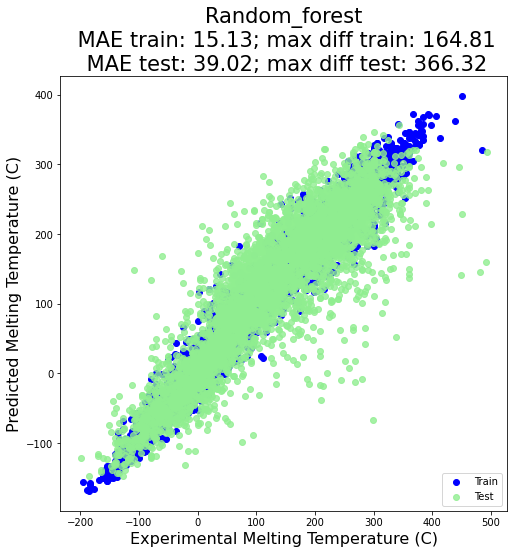

\begin{tabular}{c c c}
           name     &     test MAE err   & .    abs error in CV \\ 
\hline
                 Random_forest & 39.021 & 43.596 \\
\end{tabular}


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.model_selection import cross_val_score

import pickle


def make_scatter_plot(y_pred_train, y_pred_test, y_train, y_test, title, figsize, fontsize, fname):    
    plt.clf()
    f = plt.figure(figsize=figsize)
    plt.scatter(y_train,y_pred_train, label = 'Train', c='blue')
    plt.title(title,fontsize=fontsize+5)
    plt.xlabel('Experimental Melting Temperature (C)', fontsize=fontsize)
    plt.ylabel('Predicted Melting Temperature (C)', fontsize=fontsize)
    plt.scatter(y_test,y_pred_test,c='lightgreen', label='Test', alpha = 0.8)
    plt.legend(loc=4)
    #plt.xlim(-200,500)
    #plt.ylim(-200,500)
    plt.show()
    f.savefig(fname+".pdf")

from sklearn.model_selection import train_test_split

def test_models_and_plot(x, y, model_dict, plots, fp_case, fp_len):
    ''' test a bunch of models and print out a sorted list of CV accuracies
        inputs: 
            x: training data features, numpy array or Pandas dataframe
            y: training data labels, numpy array or Pandas dataframe
            model_dict: a dictionary of the form {name : model()}, where 'name' is a string
                        and 'model()' is a scikit-learn model object. 
    '''

    mean_scores = {}
    percent_errors = {}
    save_models = []
    
    for (name, model) in model_dict.items():
        #print("running %s" % name)
        scores = cross_val_score(model, x, y, cv=20, n_jobs=-1, scoring='neg_mean_absolute_error')
        scores = -1*scores
        mean_score = scores.mean()
        mean_scores[name] = mean_score

        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
        model.fit(X_train, y_train)
        
        # save the model to disk
        #filename = name + "_" + str(fp_case) + "_" + str(fp_len) + ".sav"
        #pickle.dump(model, open(filename, 'wb'))
        
        save_models.append(model)
        
        y_pred_train = model.predict(X_train)
        mae_train = np.mean(np.abs(y_train-y_pred_train))
        max_train = np.max(np.abs(y_train-y_pred_train))
        y_pred_test  = model.predict(X_test)
        mae_test = np.mean( np.abs(y_test -y_pred_test))
        max_test = np.max( np.abs(y_test -y_pred_test) )
        
        percent_errors[name] = mae_test

        #fulltitle = name+'\n MAE error: '+str(percent_error)
        fulltitle = name + \
            "\n MAE train: " +  str("{:.2f}".format(mae_train)) + "; max diff train: " +  str("{:.2f}".format(max_train)) + \
            "\n MAE test: " +  str("{:.2f}".format(mae_test)) + "; max diff test: " +  str("{:.2f}".format(max_test))
        

        if plots:
            fname = name + "_" + str(fp_case) + "_" + str(fp_len)
            make_scatter_plot(y_pred_train, y_pred_test, y_train, y_test, fulltitle, (8,8), 16, fname)

    sorted_names = sorted(percent_errors, key=mean_scores.__getitem__, reverse=False)

    print("\\begin{tabular}{c c c}")
    print("           name     &     test MAE err   & .    abs error in CV \\\\ ")
    print("\\hline")
    for i in range(len(sorted_names)):
        name = sorted_names[i]
        print("%30s & %5.3f & %5.3f \\\\" % (name, percent_errors[name], mean_scores[name]))
    print("\\end{tabular}")
    
    return save_models


alpha_grid = {'alpha': np.logspace(1e-11,1e-1,8)}

model_dict = {
            #'Linear_Regression': LinearRegression(),
            #'Kernel Ridge Regression': KernelRidge(),
            #'Ridge Regression':Ridge(),
            #'Gaussian Process Regressor': GaussianProcessRegressor(normalize_y=True),
            #'Support Vector Regression': SVR(),
            #'KNeighborsRegressor': KNeighborsRegressor(),
            #'Gradient_Boosted_Trees': GradientBoostingRegressor(n_estimators=100),
            'Random_forest': RandomForestRegressor(n_estimators=100)
            #'Neural_Network': MLPRegressor(alpha=1000,max_iter=8000, hidden_layer_sizes=[800,600], early_stopping=False)
            }

save_models = test_models_and_plot(X, y, model_dict, plots=True, fp_case=fp_case, fp_len=fp_len)

In [24]:
import glob

filename = "A.txt"
print("read SMILES from file:", filename)
smiles = np.loadtxt(filename, dtype=str)

for tsmiles in smiles:
    print ("**********************************")
    print (tsmiles)
    tmol = Chem.MolFromSmiles(tsmiles)
    fp = generate_fingerprint(tmol, fp_case, fp_len)
    X = np.array(list(fp))
    
    X1 = []
    if fp_element_count:
        Zelement = 6
        X1.append(element_count(tmol, Zelement))
        Zelement = 7
        X1.append(element_count(tmol, Zelement))
        Zelement = 8
        X1.append(element_count(tmol, Zelement))
        X1 = np.array(X1)
        X = np.concatenate((X,X1), axis=0)
    if fp_add_fp2:
        fp_2 = generate_fingerprint(tmol, fp_case+1, fp_len)
        X2 = np.array(list(fp_2))
        X = np.concatenate((X,X2), axis=0)
    if fp_add_fp3:
        fp_3 = generate_fingerprint(tmol, fp_case+2, fp_len)
        X3 = np.array(list(fp_3))
        X = np.concatenate((X,X3), axis=0)

        
    nlen = X.shape[0]
    X = np.reshape(X, (1, nlen)) 
    print ("The shape of the fingerprint is", X.shape)
    X = st.transform(X)
    
    #postname = "_" + str(fp_case) + "_" + str(fp_len) + ".sav"
    #files_model = glob.glob('*'+postname)
    #for f in files_model:
    #    model = pickle.load(open(f, 'rb'))
    #    y_pred = model.predict(X)
    #    print (f, y_pred)
    
    id_model = 0
    for model in save_models:
        id_model += 1
        y_pred = model.predict(X)
        print ("model-" + str(id_model), y_pred)

read SMILES from file: A.txt
**********************************
CO[N+](=O)[O-]
The shape of the fingerprint is (1, 79)
model-1 [-63.2053]
**********************************
CCO[N+](=O)[O-]
The shape of the fingerprint is (1, 79)
model-1 [-58.54564583]
**********************************
C(C(CO[N+](=O)[O-])O[N+](=O)[O-])O[N+](=O)[O-]
The shape of the fingerprint is (1, 79)
model-1 [16.4235]
**********************************
C(C(CO[N+](=O)[O-])(CO[N+](=O)[O-])[N+](=O)[O-])O[N+](=O)[O-]
The shape of the fingerprint is (1, 79)
model-1 [-6.41666667]
**********************************
CC(CO[N+]([O-])=O)(CO[N+]([O-])=O)CO[N+]([O-])=O
The shape of the fingerprint is (1, 79)
model-1 [-6.50116667]
**********************************
C(C(CO[N+](=O)[O-])(CO[N+](=O)[O-])CO[N+](=O)[O-])O[N+](=O)[O-]
The shape of the fingerprint is (1, 79)
model-1 [-2.79978333]
